## Annotation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/a-nadeem9/brca-epigenetic-age-acceleration-immune-multiomics-classifier/blob/main/notebooks/06_annotation.ipynb)


In [51]:
# Install BiocManager if needed
if (!requireNamespace("BiocManager", quietly = TRUE)) {
  install.packages("BiocManager", quiet = TRUE)
}

# List all packages you need
pkgs <- c(
  "clusterProfiler",
  "org.Hs.eg.db",
  "ReactomePA",
  "AnnotationDbi",
  "dplyr",
  "tibble",
  "ggplot2"
)

# Install (no asking, no updating everything)
suppressWarnings(
  BiocManager::install(pkgs, ask = FALSE, update = FALSE, quiet = TRUE)
)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.22 (BiocManager 1.30.26), R 4.5.0 (2025-04-11 ucrt)



In [50]:
suppressPackageStartupMessages({
  library(clusterProfiler)
  library(org.Hs.eg.db)
  library(ReactomePA)
  library(AnnotationDbi)
  library(dplyr)
  library(tibble)
  library(ggplot2)
})

sessionInfo()


R version 4.5.0 (2025-04-11 ucrt)
Platform: x86_64-w64-mingw32/x64
Running under: Windows 11 x64 (build 26100)

Matrix products: default
  LAPACK version 3.12.1

locale:
[1] LC_COLLATE=English_United Kingdom.utf8 
[2] LC_CTYPE=English_United Kingdom.utf8   
[3] LC_MONETARY=English_United Kingdom.utf8
[4] LC_NUMERIC=C                           
[5] LC_TIME=English_United Kingdom.utf8    

time zone: Europe/Berlin
tzcode source: internal

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] patchwork_1.3.1        purrr_1.0.4            tidyr_1.3.1           
 [4] viridisLite_0.4.2      scales_1.4.0           stringr_1.5.1         
 [7] forcats_1.0.0          ggplot2_3.5.2          tibble_3.3.0          
[10] dplyr_1.1.4            ReactomePA_1.53.0      org.Hs.eg.db_3.21.0   
[13] AnnotationDbi_1.71.0   IRanges_2.43.0         S4Vectors_0.47.0      
[16] Biobase_2.69.0         BiocGenerics_0.55.0    

In [7]:
# 1) Ensembl ID vector
features_all <- c(
  "ENSG00000054598","ENSG00000186832","ENSG0000005513",
  "ENSG00000198729","ENSG00000186868","ENSG00000154548",
  "ENSG00000259793","ENSG00000172425","ENSG00000254615",
  "ENSG00000082175","ENSG00000204385","ENSG00000148513",
  "ENSG00000236313","ENSG00000135912","ENSG00000234918"
)


features_sig <- features_all

In [8]:
is_ensembl <- function(x) grepl("^ENSG\\d{11}$", x)

bad_all <- features_all[!is_ensembl(features_all)]
if (length(bad_all)) {
  message("Dropping malformed Ensembl IDs (ALL): ",
          paste(bad_all, collapse = ", "))
}
features_all <- features_all[is_ensembl(features_all)]

if (length(features_sig)) {
  bad_sig <- features_sig[!is_ensembl(features_sig)]
  if (length(bad_sig)) {
    message("Dropping malformed Ensembl IDs (SIG): ",
            paste(bad_sig, collapse = ", "))
  }
  features_sig <- features_sig[is_ensembl(features_sig)]
}

length(features_all)
length(features_sig)


Dropping malformed Ensembl IDs (ALL): ENSG0000005513

Dropping malformed Ensembl IDs (SIG): ENSG0000005513



[1] 14

[1] 14

In [9]:
map_all <- bitr(features_all,
                fromType = "ENSEMBL",
                toType   = "ENTREZID",
                OrgDb    = org.Hs.eg.db)

entrez_all <- unique(map_all$ENTREZID)
length(entrez_all)

if (length(features_sig)) {
  map_sig <- bitr(features_sig,
                  fromType = "ENSEMBL",
                  toType   = "ENTREZID",
                  OrgDb    = org.Hs.eg.db)
  entrez_sig <- unique(map_sig$ENTREZID)
  length(entrez_sig)
} else {
  entrez_sig <- character(0)
}


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(features_all, fromType = "ENSEMBL", toType = "ENTREZID", :
"21.43% of input gene IDs are fail to map..."


[1] 11

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(features_sig, fromType = "ENSEMBL", toType = "ENTREZID", :
"21.43% of input gene IDs are fail to map..."


[1] 11

In [10]:
ego_all <- enrichGO(
  gene          = entrez_all,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENTREZID",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1,
  readable      = TRUE
)


In [11]:
ekegg_all <- enrichKEGG(
  gene          = entrez_all,
  organism      = "hsa",
  keyType       = "ncbi-geneid",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)

# Make gene IDs readable (map Entrez back to gene symbols)
ekegg_all <- setReadable(ekegg_all, OrgDb = org.Hs.eg.db, keyType = "ENTREZID")


Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...

Reading KEGG annotation online: "https://rest.kegg.jp/conv/ncbi-geneid/hsa"...



In [12]:
ereact_all <- enrichPathway(
  gene          = entrez_all,
  organism      = "human",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1,
  readable      = TRUE
)


In [85]:
# Load the stringr library for text wrapping
library(stringr)

# --- Enhanced Bar Plot Function ---
safe_barplot <- function(enrich_result, title, showCategory = 20) {
  # Check if there's anything to plot
  if (!is.null(enrich_result) && nrow(as.data.frame(enrich_result)) > 0) {
    p <- barplot(enrich_result, showCategory = showCategory) +
      labs(
        title = title,
        x = "Gene Ratio",
        y = "Enriched Term"
      ) +
      # Wrap long labels on the y-axis to 40 characters
      scale_y_discrete(labels = function(x) str_wrap(x, width = 40)) +
      theme_minimal(base_size = 14) +
      theme(plot.title = element_text(hjust = 0.5)) # Center the title

    print(p)
  } else {
    message("No terms to plot for: ", title)
  }
}



In [42]:
# Filter each result for adjusted p-value < 0.05
ego_all_df <- as.data.frame(ego_all)
ekegg_all_df <- as.data.frame(ekegg_all)
ereact_all_df <- as.data.frame(ereact_all)

ego_sig <- ego_all_df %>% filter(p.adjust < 0.05)
ekegg_sig <- ekegg_all_df %>% filter(p.adjust < 0.05)
ereact_sig <- ereact_all_df %>% filter(p.adjust < 0.05)

# See how many significant GO terms you have
print(paste("Found", nrow(ego_sig), "significant GO terms."))

[1] "Found 0 significant GO terms."


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


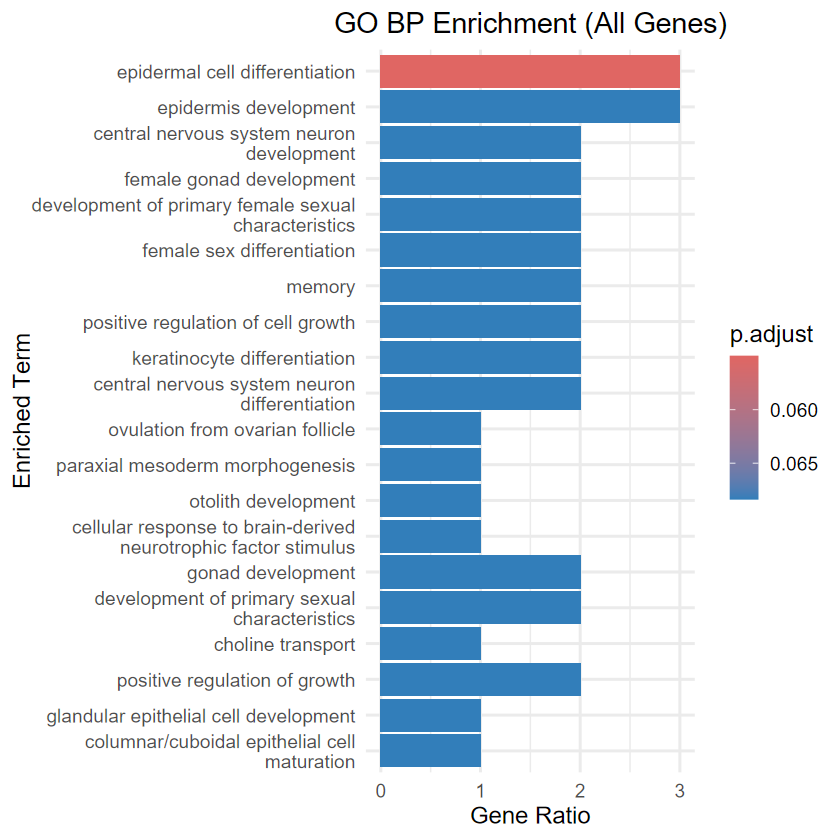

In [82]:
safe_barplot(ego_all, "GO BP Enrichment (All Genes)")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


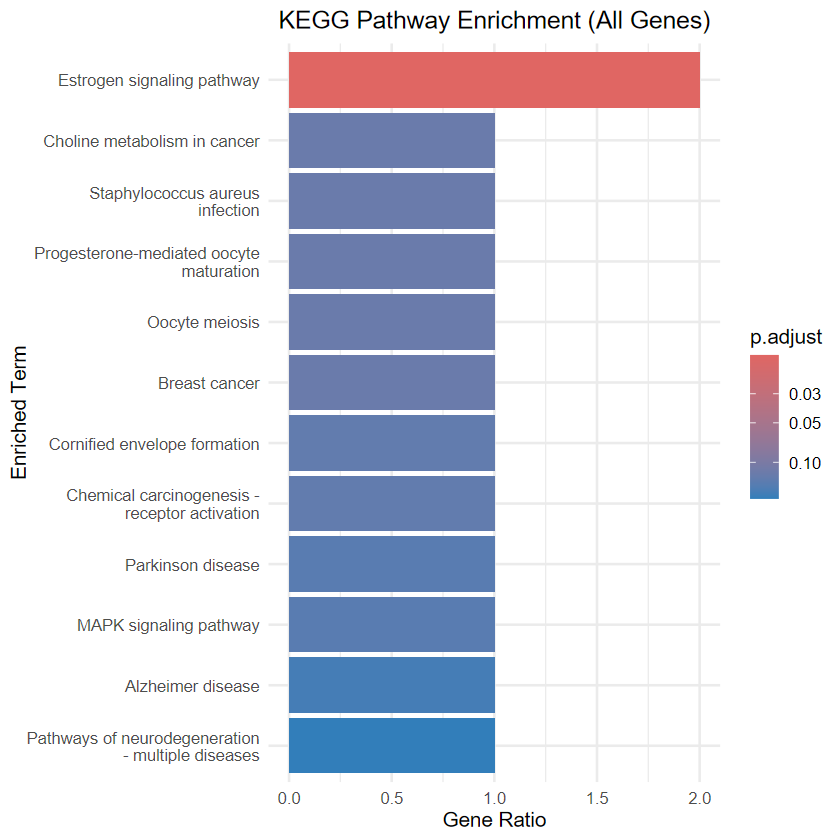

In [64]:
safe_barplot(ekegg_all, "KEGG Pathway Enrichment (All Genes)")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


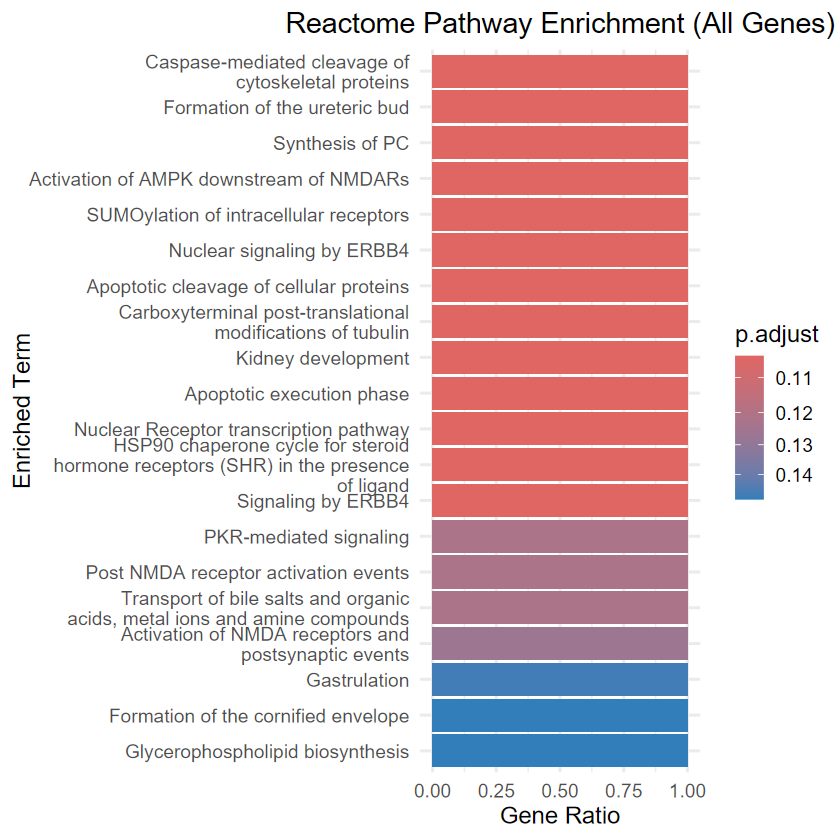

In [86]:
safe_barplot(ereact_all, "Reactome Pathway Enrichment (All Genes)")